## 다양한 OCR모델 비교하기

OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을것도 같습니다.  

한번 어떤 서비스를 제공할지를 생각해보고 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되었다고 가정해서 어떤 모듈을 도입하면 좋을지 기술검증도 진행해보겠습니다.

### 1. 검증용 데이터셋 준비
---

검증용 데이터 셋으로 한글 간판 이미지를 문자의 배치, 크기에 따라 다양한 유형에 데이터를 각 부문별로 준비 했습니다.  

간편한 비교를 위해 이미지는 10장을 사용하였고 **수평 바른 배치**, **수지 바른 배치**, **자유로운 배치**, **캘리그라피** 이렇게 총 4가지 경우를 두고 API의 성능을 비교해 보겠습니다.

### 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
---
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

### Module import

In [1]:
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

## 구글 OCR API 
- 구글 OCR API를 코드로 사용하려면 계정 결제 과정이 필요하므로 구글 자체에서 OCR API하는 사이트에서 이미지를 넣어보면서 진행하겠습니다.

아래에 코드가 Google에서 API 인증키를 받아 API를 사용할 수 있는 코드입니다.   

구글 OCR API를 사용하려면 인증키를 받고난 후 구글 계정에서 실제 카드를 등록해야지 진행이 되기 때문에 해당 부분은 진행하지 않고 구글 OCR API를 사용해 볼 수 있는 사이트 [Google Cloud Vision API](https://cloud.google.com/vision/?utm_source=google&utm_medium=cpc&utm_campaign=japac-KR-all-en-dr-bkws-all-all-trial-e-dr-1008074&utm_content=text-ad-none-none-DEV_c-CRE_252596144846-ADGP_Hybrid%20%7C%20AW%20SEM%20%7C%20BKWS%20~%20T1%20%7C%20EXA%20%7C%20ML%20%7C%20M%3A1%20%7C%20KR%20%7C%20en%20%7C%20Vision%20%7C%20API-KWID_43700029837773855-kwd-316837066534&userloc_1009877&utm_term=KW_google%20vision%20api%20ocr&gclid=Cj0KCQiAyp7yBRCwARIsABfQsnRMFOzgV84oX2MTWrPMvaE_JgjgTshUaLE6LYrsk8lM23-43gBfCkMaAnGaEALw_wcB)에서 이미지를 올리고 출력된 결과를 캡처해서 가지고 오겠습니다.

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [3]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME') + '/aiffel/ocr_python/구글 OCR API.png'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)


'\n# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. \n!ls -l $GOOGLE_APPLICATION_CREDENTIALS\n\nimport os\nos.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv(\'HOME\')+\'/aiffel/ocr_python/my_google_api_key.json\'\n\n# 입력 이미지 경로를 지정해 주세요.\n# (예시) path = os.getenv(\'HOME\')+\'/aiffel/ocr_python/test_image.png\'\npath = os.getenv(\'HOME\') + \'/aiffel/ocr_python/구글 OCR API.png\'\n\n# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.\ndetect_text(path)\n\n'

In [21]:
google_ocr_dir = os.getenv('HOME')+'/aiffel/ocr_python/korea/google_ocr_Result'
google_ocr_dir

'/home/ssac27/aiffel/ocr_python/korea/google_ocr_Result'

### 바른 배치 한글 문자 검출
- 한글의 글자 배치가 수평으로 되어 있는 이미지를 위의 [Google Cloud Vision API](https://cloud.google.com/vision/?utm_source=google&utm_medium=cpc&utm_campaign=japac-KR-all-en-dr-bkws-all-all-trial-e-dr-1008074&utm_content=text-ad-none-none-DEV_c-CRE_252596144846-ADGP_Hybrid%20%7C%20AW%20SEM%20%7C%20BKWS%20~%20T1%20%7C%20EXA%20%7C%20ML%20%7C%20M%3A1%20%7C%20KR%20%7C%20en%20%7C%20Vision%20%7C%20API-KWID_43700029837773855-kwd-316837066534&userloc_1009877&utm_term=KW_google%20vision%20api%20ocr&gclid=Cj0KCQiAyp7yBRCwARIsABfQsnRMFOzgV84oX2MTWrPMvaE_JgjgTshUaLE6LYrsk8lM23-43gBfCkMaAnGaEALw_wcB) 사이트에 접속한 후 이미지를 넣고 결과 화면을 가지고 옵니다.

그리고 결과를 glob로 폴더째 로드한 후 pyplot로 해당 이미지를 시각화 하겠습니다.  

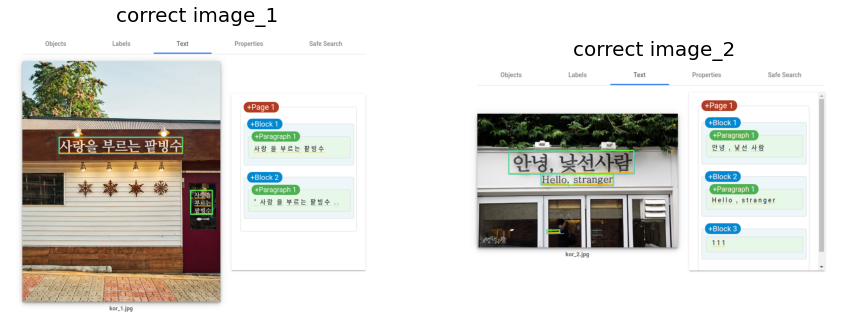

In [31]:
# 바른 배치를 가진 이미지 가져오기
correct_images = [Image.open(file) for file in glob.glob(google_ocr_dir+"/Correct_placement/*.*")]
labels = "correct image_"

plt.figure(figsize = (15,15))
for i, corr in enumerate(correct_images):
    plt.subplot(1,2,i+1)
    plt.title(labels+str(i+1), fontsize=20)
    plt.axis('off')
    plt.imshow(corr)
    


위의 3 오픈소스 API 중 카드를 등록하고 계정을 활성화 해야지 할 수 있는 API이다 보니 좋은 결과가 나왔습니다.  
한글 문자도 인식을 잘 했으면서, 문장 단위도 뛰어쓰기가 잘 되어 있네요.

###  수직 한글 문자 검출
- 한글의 글자 배치가 수직인 간판 이미지들을 [Google Cloud Vision API](https://cloud.google.com/vision/?utm_source=google&utm_medium=cpc&utm_campaign=japac-KR-all-en-dr-bkws-all-all-trial-e-dr-1008074&utm_content=text-ad-none-none-DEV_c-CRE_252596144846-ADGP_Hybrid%20%7C%20AW%20SEM%20%7C%20BKWS%20~%20T1%20%7C%20EXA%20%7C%20ML%20%7C%20M%3A1%20%7C%20KR%20%7C%20en%20%7C%20Vision%20%7C%20API-KWID_43700029837773855-kwd-316837066534&userloc_1009877&utm_term=KW_google%20vision%20api%20ocr&gclid=Cj0KCQiAyp7yBRCwARIsABfQsnRMFOzgV84oX2MTWrPMvaE_JgjgTshUaLE6LYrsk8lM23-43gBfCkMaAnGaEALw_wcB) 사이트에 접속한 후 이미지를 넣고 결과 화면을 가지고 옵니다.

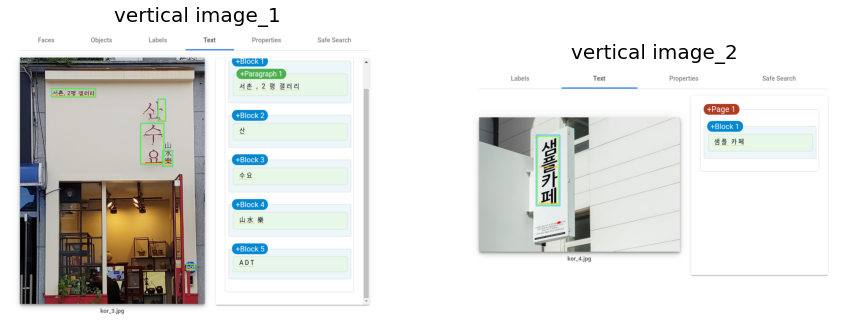

In [33]:
# 수직 배치를 가진 이미지 가져오기
vertical_images = [Image.open(file) for file in glob.glob(google_ocr_dir+"/Vertical_placement/*.*")]
labels = "vertical image_"

plt.figure(figsize = (15,15))
for i, verti in enumerate(vertical_images):
    plt.subplot(1,2,i+1)
    plt.title(labels+str(i+1), fontsize=20)
    plt.axis('off')
    plt.imshow(verti)
    


한글이 영어랑은 다르게 수직으로도 글씨를 써서 수직 간판인 경우에 API가 텍스트를 잘 검출하고 인식할 수 있는지 테스트를 진행해 봤는데 제대로 인식이 되었네요.  
또 한글뿐만 아니라 한자까지 검출하고 인식한 것을 확인할 수 있습니다.

### 자유로운 배치의 한글 문자 검출
- 한글의 글자 배치가 수평, 수직의 구애를 받지 않는 형태로 되어 있는 간판들의 이미지를 가져와서 문자 detection이 잘 되는지 확인해 봅시다.

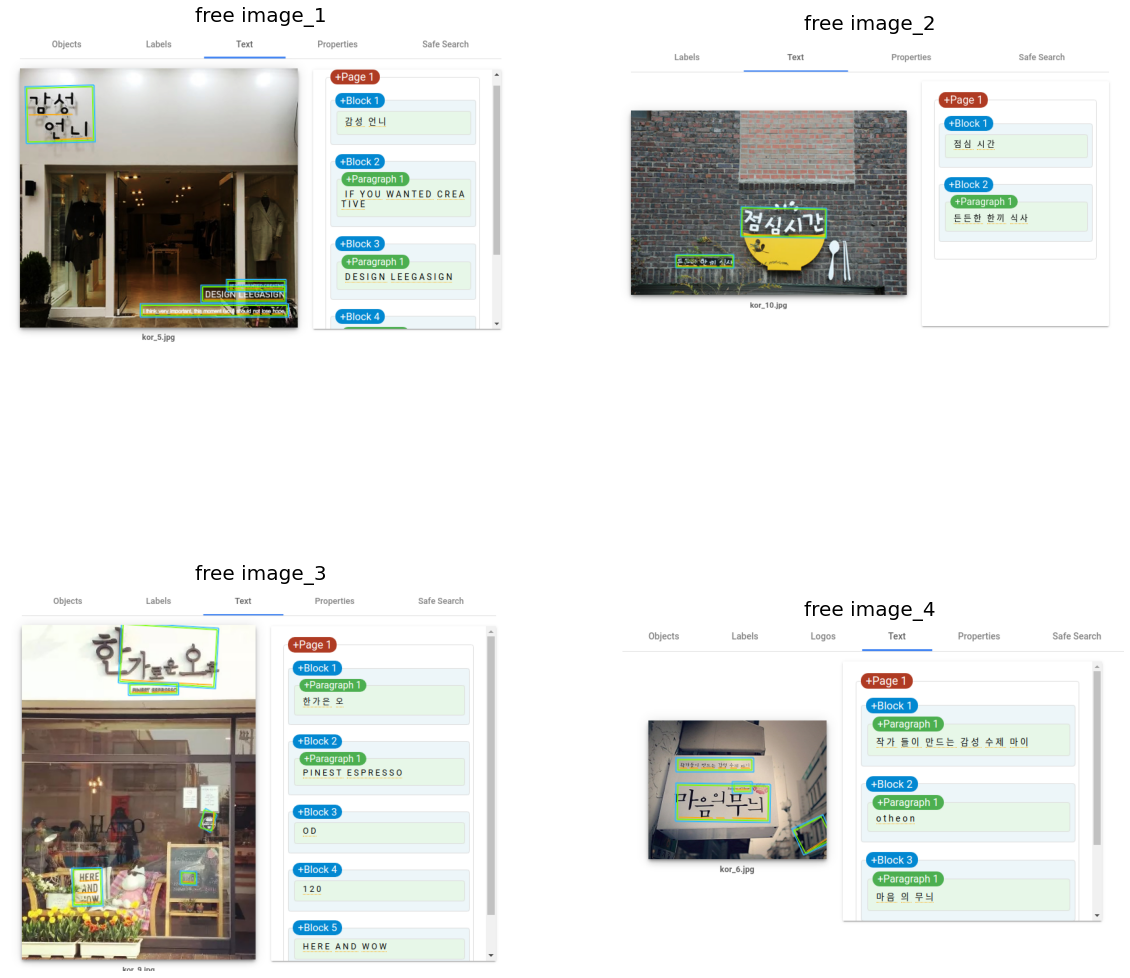

In [49]:
# 자유로운 배치를 가진 이미지 가져오기
free_images = [Image.open(file) for file in glob.glob(google_ocr_dir+"/free_placement/*.*")]
labels = "free image_"

plt.figure(figsize = (20,20))
for i, free in enumerate(free_images):
    plt.subplot(2,2,i+1)
    plt.title(labels+str(i+1), fontsize=20)
    plt.axis('off')
    plt.imshow(free)
    


글자의 크기, 글자의 위치, 글자의 배치가 수직이나 수평과 같이 바르게 써진것이 아닌 굴곡이 있는 배치를 가진 간판 이미지들을 데이터로 사용했는데 결과는 텍스트의 경우 깔끔하게 인식을 했네요.   
image_3의 경우 **'한가로운 오후'**에서 **'한가로운 오'** 부분만 검출을 했지만, 다른 결과를 보니 글자의 크기가 크게 차이가 나지 않는 이상은 제대로 검출과 인식이 잘 이루어지는것 같습니다.

### 한글 캘리그라피 문자 검출 
- 한글로 한 캘리그라피의 경우 글자의 굵기나 색상, 모양 등이 제각각으로 다릅니다.  
이런 복잡한 캘리그라피 같은 경우도 제대로 검출할 수 있는지 확인해 봅시다.

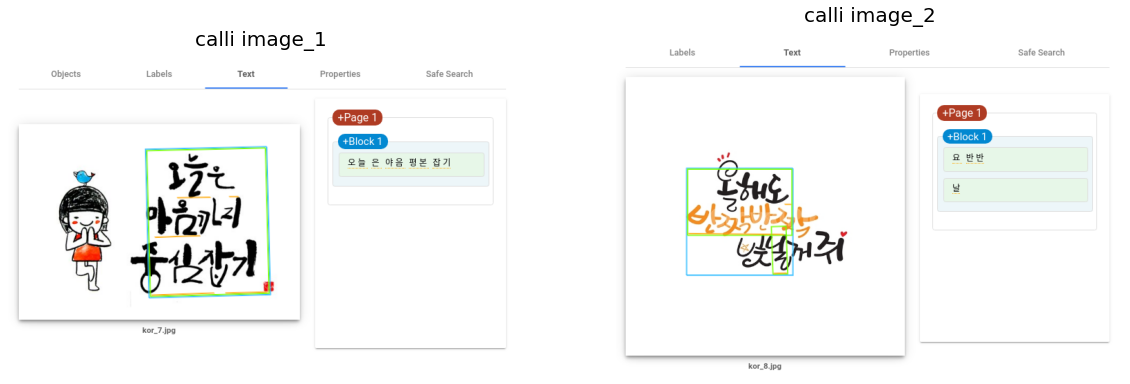

In [51]:
# 한글 캘리그라피 간판 이미지 가져오기
calli_images = [Image.open(file) for file in glob.glob(google_ocr_dir+"/calligraphy/*.*")]
labels = "calli image_"

plt.figure(figsize = (20,20))
for i, cali in enumerate(calli_images):
    plt.subplot(2,2,i+1)
    plt.title(labels+str(i+1), fontsize=20)
    plt.axis('off')
    plt.imshow(cali)
    


캘리그라피의 경우 어렵다고 생각은 했지만, 결과를 보니 아직 캘리그라피와 같은 문구의 인식은 힘든것 같습니다.  
image_1의 경우 검출과정에서 **중심** 문자를 제대로 검출해 내지 못해서 인식이 잘 안된것 같네요.  

image_2의 경우는 검출 마저도 제대로 잘 안이루어 졌네요.

---

## Keras OCR

**keras-ocr**은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줍니다. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 CRNN을 사용합니다.


keras OCR은 한글 데이터셋으로 훈련이 되어 있지 않으니 detection이 잘되는지만 확인해 보겠습니다.



In [1]:
import keras_ocr
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/ssac27/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac27/.keras-ocr/crnn_kurapan.h5


In [2]:
kor_root_dir = os.getenv('HOME')+'/aiffel/ocr_python/korea'
root_dir = os.getenv('HOME')+'/aiffel/ocr_python'
kor_root_dir

'/home/ssac27/aiffel/ocr_python/korea'

이미지의 path가 제대로 입력되어 있는지 확인해 봅시다.  
이미지를 가지고와서 확인해 봅시다.

In [23]:
# 바른 배치를 가진 이미지 가져오기
correct_images = [Image.open(file) for file in glob.glob(kor_root_dir+"/Correct_placement/*.*")]

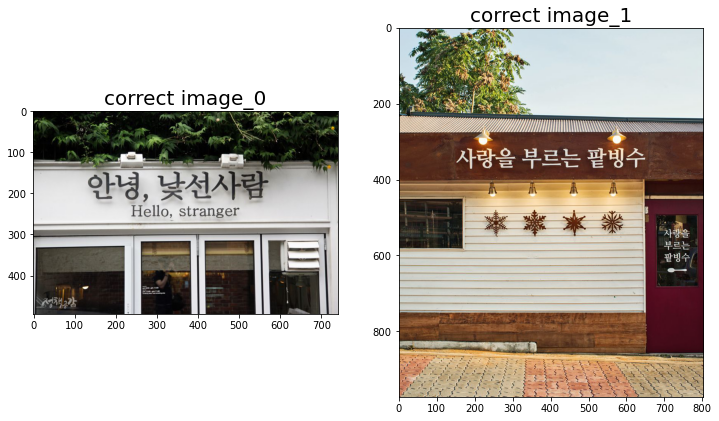

In [25]:
labels = "correct image_"
plt.figure(figsize = (12,12))
for i, corr in enumerate(correct_images):
    plt.subplot(1,2,i+1)
    plt.title(labels+str(i), fontsize=20)
    plt.imshow(corr)
    

### 바른 배치 한글 문자 검출
- 한글의 글자 배치가 수평으로 되어 있고 적당한 크기를 가진 파일 이미지를 가져와서 문자 detection이 잘 되는지 확인해 봅시다.

그리고 인식된 결과를 pyplot으로 시각화를 해봅니다.

keras pipeline은 내부적으로 **recognize()** 는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 합니다.

여기선 한글 텍스트 문자를 사용하므로 검출까지가 잘 되는지 확인해 봅시다.

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


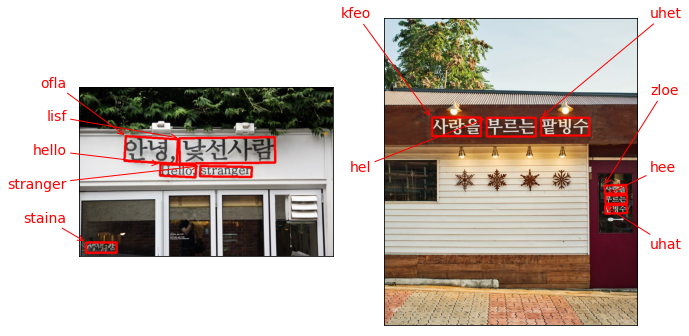

In [3]:
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/Correct_placement/*.*")]


keras_images = [keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

# Plot the predictions
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

수평 한글 문자 검출은 생각한 대로 단어 검출은 제대로 이루어 졌고 추가로 "**사랑을**" "**부르는**" "**팥빙수**"와 같이 제대로 분리되어 있네요.

수평 한글문자의 경우  
1. **한글 검출**
2. **문장 단위 검출**

위의 2가지를 모두 만족했습니다.

###  수직 한글 문자 검출
- 한글의 글자 배치가 수직인 간판들의 detection이 잘 되는지 확인해 봅시다.

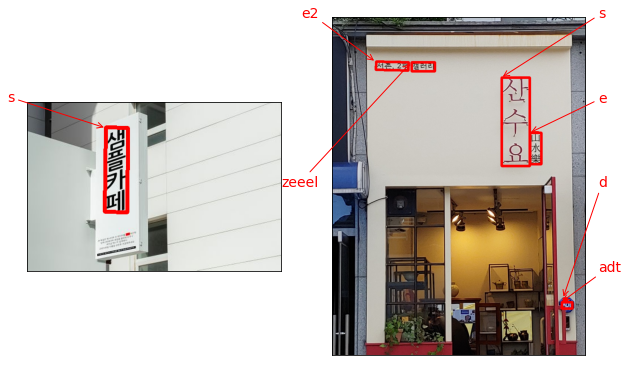

In [13]:
# image path from local
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/Vertical_placement/*.*")]

# use keras_ocr detection image 
keras_images = [keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

# Plot the predictions
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

Keras-OCR 모델이 한글 데이터셋을 학습하지 않은 모델이여서 세로로 쓰는 글씨의 경우 세로로 쓴 문장 전체의 검출이 아닌 한 단어씩 검출해 낼줄 알았는데 **수직 한글배치**도 **수평 한글배치**와 마찬가지로 단어를 기준으로 검출이 잘 이루어 졌습니다. 

수직 한글문자의 경우도 수평 한글 문자와 같습니다.
1. **한글 검출**
2. **문장 단위 검출**

위의 2가지를 모두 만족했습니다.

### 자유로운 배치의 한글 문자 검출
- 한글의 글자 배치가 수평, 수직의 구애를 받지 않는 형태로 되어 있는 간판들의 이미지를 가져와서 문자 detection이 잘 되는지 확인해 봅시다.

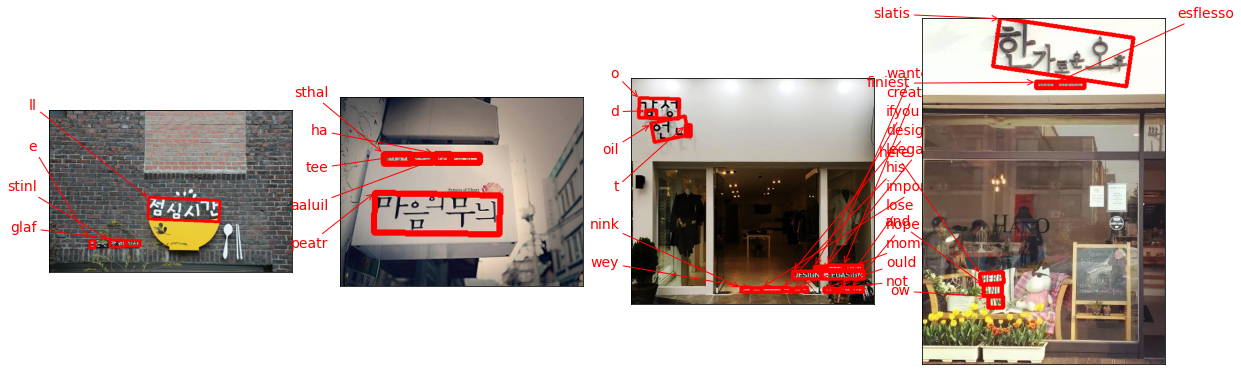

In [14]:
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/free_placement/*.*")]


keras_images = [keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

# Plot the predictions
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

위의 수평 배치, 수직 배치의 경우 보다 더 복잡한 한글 검출이 제대로 되었습니다.  
위의 수평, 수직과는 다르게 글자의 배치도 제각각이고 또 몇몇 글자의 경우 글자의 크기 자체도 차이가 나고 있지만, 글자의 검출은 제대로 이루어 졌습니다. 
글자 검출 Box안에 한글이 제대로 들어가 있네요. Keras-OCR 모델의 Robustness을 알 수 있는것 같습니다.

문자 배치와 글자 크기가 자유로워도
1. **한글 검출**
2. **문장 단위 검출**

위의 2가지를 모두 만족했습니다.

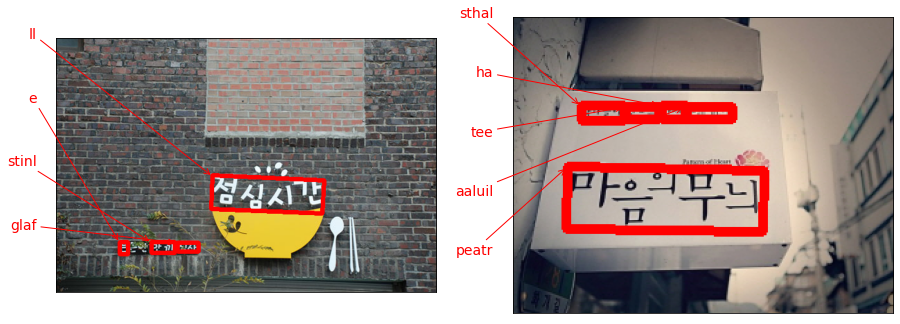

In [28]:
# 위의 이미지 중 2개를 좀 더 크게 만들어서 글자가 제대로 들어갔는지 확인해 봅시다.
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

Keras-OCR 모델의 글자 검출이 굉장히 잘 되었습니다.  
마지막으로 프린트할 때 사용하는 정교한 글씨가 아닌 손글씨인 한글 캘리그라피도 제대로 detection 할 수 있는지 체크해 봅시다.

### 한글 캘리그라피 문자 검출 
- 한글로 한 캘리그라피의 경우 글자의 굵기나 색상, 모양 등이 제각각으로 다릅니다.  
이런 복잡한 캘리그라피 같은 경우도 제대로 검출할 수 있는지 확인해 봅시다.

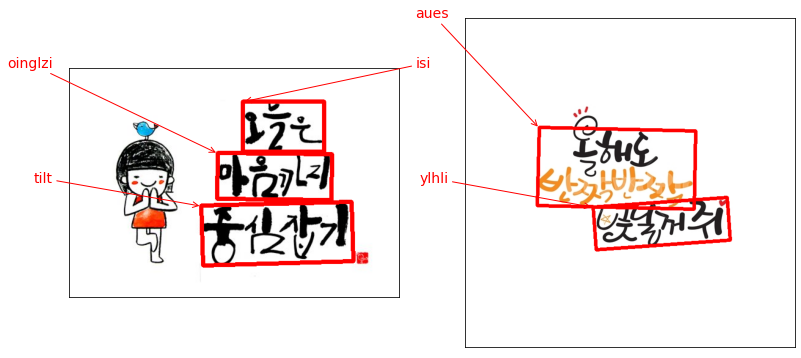

In [29]:
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/calligraphy/*.*")]


keras_images = [keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

# Plot the predictions
fig, axs = plt.subplots(1, 2, figsize=(13, 13))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

캘리그라피의 경우 text-stroke가 제각기 다르고 각 글자의 배치도 달라서 검출하기 힘들것 같았지만, Keras-OCR 모델이 한글을 잘 검출을 했네요.  
오른쪽의 **올해도**에서 **'ㅇ'**의 일부분이 짤렸지만, 이 정도면 검출을 잘 해낸것 같습니다.   

캘리그라피의 경우 Google OCR API 보다 keras-ocr이 더 검출을 잘 하고 있습니다.  

---

## Tesseract

이번에는 테서랙트(Tesseract) 라이브러리로 이미지에서 문자를 인식해 보겠습니다. 
테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함해 다양한 국어를 지원하고 있습니다.  

테서렉트로 문자를 검출한 후 인식을 진행하겠습니다.  
테서렉트로 10개의 이미지를 검출하고 인식하면 결과가 텍스트로 출력되기 때문에 깔끔한 검출 및 인식 비교를 위해 위의 **바른배치**, **수직 배치**, **자유로운 배치**, **캘리그라피**에서 1개의 이미지로만 진행하겠습니다. 

### 바른 배치 한글 문자 검출
- 수평 한글 문자검출을 진행하겠습니다.

#### [1] 테서랙트로 문자 검출하고 이미지 자르기 (Detection)
---
테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데요. 우리는 OCR이 이뤄지는 전체과정을 직접 거쳐보기 위해 검출을 먼저 해 봅시다.


In [92]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor' , 영어는 lanag='eng'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path+'/Tesseract_result', f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [32]:
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/Correct_placement/*.*")]


In [48]:
kor_root_dir

'/home/ssac27/aiffel/ocr_python/korea'

In [58]:
cropped_image_path_list = crop_word_regions(image_paths[1], kor_root_dir)

/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0000.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0001.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0002.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0003.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0004.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0005.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0006.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0007.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0008.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0009.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0010.png


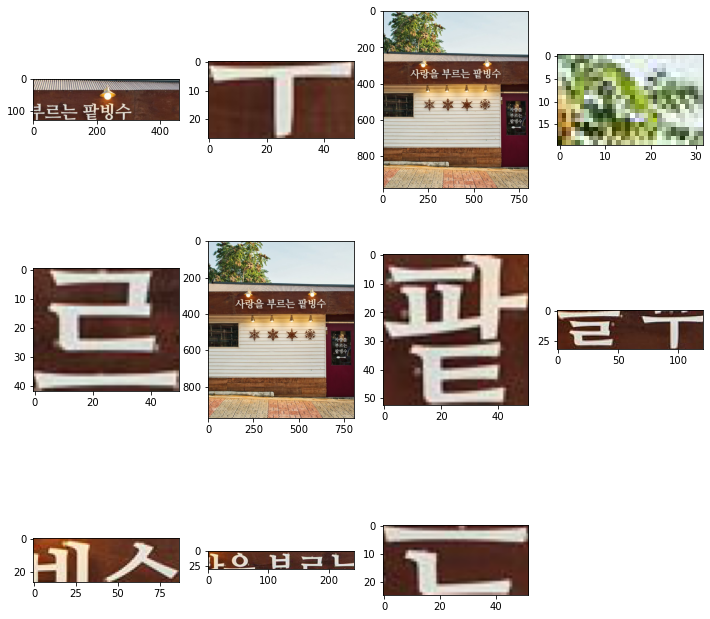

In [59]:
# 위에서 detection한 이미지를 가져오겠습니다.
Tesseract_detection_images = [Image.open(file) for file in glob.glob(kor_root_dir+"/Tesseract_result/*.*")]

plt.figure(figsize = (12,12))
for i, tesseract in enumerate(Tesseract_detection_images):
    plt.subplot(3,4,i+1)
    plt.imshow(tesseract)

위에서 구현한 **crop_word_regions()** 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.  

기본적으로 **pytesseract.image_to_data()** 를 사용합니다. 파이썬에서 편하게 사용하기 위해서 **pytesseract** 의 **Output** 을 사용해서 결과값의 형식을 딕셔너리(**DICT**) 형식으로 설정해주게 됩니다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 됩니다. 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 **PIL(pillow)** 또는 **opencv** 라이브러리를 사용해 잘라(crop)서 **cropped_image_path_list**에 담아 리턴하였습니다.

#### [2] 테서랙트로 잘린 이미지에서 단어 인식하기
---
이제 문자 인식을 해 볼 차례입니다. 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결과값으로 나오는 **image_to_string()**를 사용하게 됩니다.

이렇게 인식된 결과가 실제 이미지와 맞는지 확인해 봅시다.

In [93]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [60]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)



=

때 ㅣ

)매000 =00=- 0

6 아

(로:

은 ~

배도



Done


위의 2 경우에서랑은 검출도 제대로 안되고 인식도 제대로 안되는군요.  


### 수직 한글 문자 검출
- 수직 한글 문자검출 부터는 검출과 인식을 한번에 진행해 보겠습니다.

In [44]:
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/Vertical_placement/*.*")]

In [45]:
cropped_image_path_list = crop_word_regions(image_paths[0], kor_root_dir)

/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0000.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0001.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0002.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0003.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0004.png


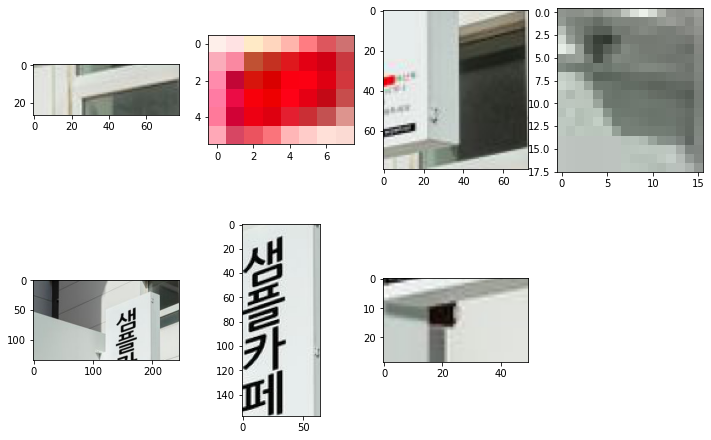

In [25]:
# 위에서 detection한 이미지를 가져오겠습니다.
Tesseract_detection_images = [Image.open(file) for file in glob.glob(kor_root_dir+"/Tesseract_result/*.*")]

plt.figure(figsize = (12,12))
for i, tesseract in enumerate(Tesseract_detection_images):
    plt.subplot(3,4,i+1)
    plt.imshow(tesseract)

In [26]:
recognize_images(cropped_image_path_list)


- 즈


개

~

테

|

Done


수평 한글 배치와 마찬가지로 괜찮은 결과가 나오질 않네요.  
언어 설정을 한글('kor')로 하긴 했지만, 한글이 제대로 인식이 안되서 생기는 문제일 수 있으니 영어간판으로 테스트 해보겠습니다.

### 영어 간판 인식
- 한글 간판으로 했을때 성능이 잘안나오니 영어 간판으로 검출과 인식을 테스트해보겠습니다.

In [80]:
eng_root_dir = os.path.join(root_dir,'eng')
eng_root_dir

'/home/ssac27/aiffel/ocr_python/eng'

In [81]:
image_paths = [image_path for image_path in glob.glob(eng_root_dir+"/*.*")]
image_paths

['/home/ssac27/aiffel/ocr_python/eng/eng_2.jpg',
 '/home/ssac27/aiffel/ocr_python/eng/eng_1.jpeg']

영어간판 원본 이미지


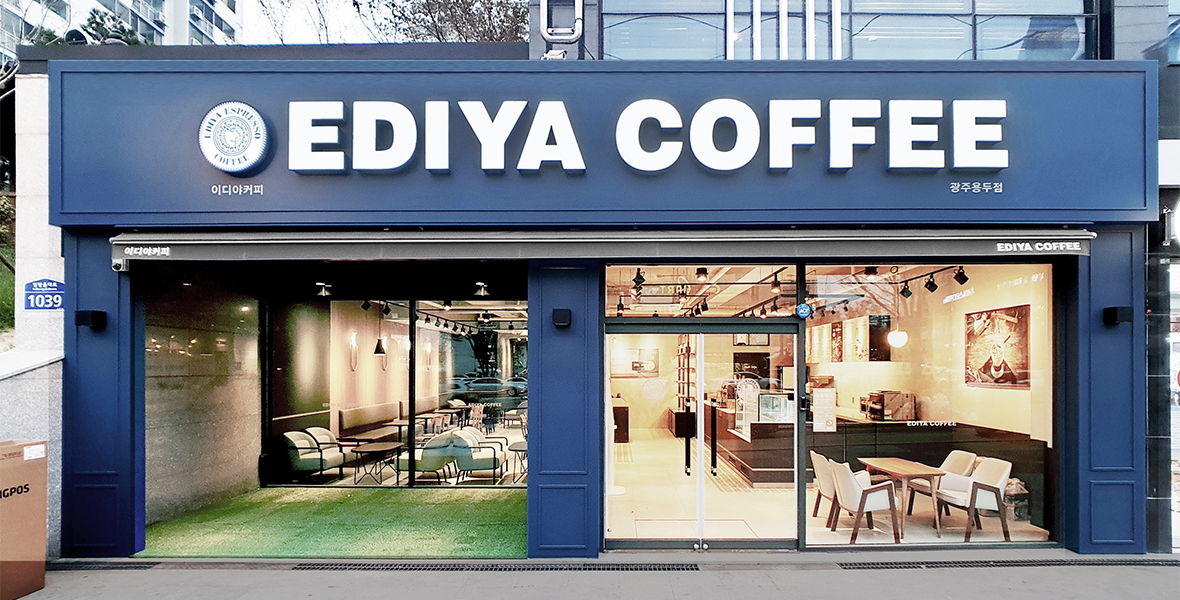

In [89]:
print("영어간판 원본 이미지")
Image.open(image_paths[0])
    

In [82]:
cropped_image_path_list = crop_word_regions(image_paths[0], eng_root_dir)

/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0000.png
/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0001.png
/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0002.png
/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0003.png
/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0004.png
/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0005.png
/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0006.png
/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0007.png
/home/ssac27/aiffel/ocr_python/eng/Tesseract_result/0008.png


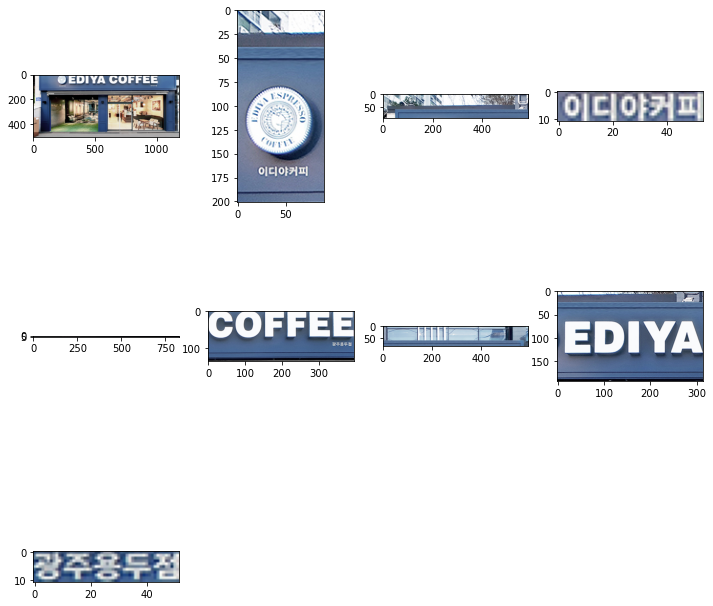

In [83]:
# 위에서 detection한 이미지를 가져오겠습니다.
Tesseract_detection_images = [Image.open(file) for file in glob.glob(eng_root_dir+"/Tesseract_result/*.*")]

plt.figure(figsize = (12,12))
for i, tesseract in enumerate(Tesseract_detection_images):
    plt.subplot(3,4,i+1)
    plt.imshow(tesseract)

In [84]:
recognize_images(cropped_image_path_list)

eS NS



a

oh

COFFEE

OICIOFA DI

fo or’

— rere

Done


언어 설정을 영어로 하니 한글 간판들 보다는 그럴듯한 단어가 보이네요.  
그렇지만 영어 간판도 인식이 제대로 안되고 있습니다.  
EDIYA COFFEE만 검출 해야하는데 영어가 아닌 다른 이미지 박스도 보이고 검출한 이미지에서 영어 텍스트를 제대로 인식해야하는데 **EDIYA COFFEE**에서 **COFFEE**만 제대로 인식을 했습니다.  

남은 부문들의 한글 검출과 인식이 어려울 것 같지만 결과가 어떻게 나올지 확인해 봅시다.

### 자유로운 배치의 한글 문자 검출
- 한글의 글자 배치가 수평, 수직의 구애를 받지 않는 형태로 되어 있는 간판들의 이미지를 가져와서 문자 detection과 recognition이 잘 되는지 확인해 봅시다.

In [132]:
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/free_placement/*.*")]

In [133]:
cropped_image_path_list = crop_word_regions(image_paths[0], kor_root_dir)

/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0000.png


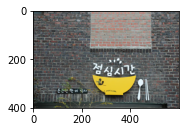

In [134]:
# 위에서 detection한 이미지를 가져오겠습니다.
Tesseract_detection_images = [Image.open(file) for file in glob.glob(kor_root_dir+"/Tesseract_result/*.*")]

plt.figure(figsize = (12,12))
for i, tesseract in enumerate(Tesseract_detection_images):
    plt.subplot(3,4,i+1)
    plt.imshow(tesseract)

In [135]:
recognize_images(cropped_image_path_list)

| =

Done


결과를 보면 이미지에서 텍스트 검출과 인식이 잘 안된것을 확인할 수 있습니다.  
위의 수직, 수평 결과가 좋지 않아서 free placement도 잘 안될것 같았지만 검출이랑 인식이 이렇게 안될줄은 몰랐네요.

마지막으로 한글 캘리그라피에서 텍스트 검출과 인식을 진행하겠습니다.

### 한글 캘리그라피 검출
- Tesseract로 한글 캘리그라피의 검출과 인식을 진행하겠습니다.

In [96]:
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/calligraphy/*.*")]

In [97]:
cropped_image_path_list = crop_word_regions(image_paths[0], kor_root_dir)

/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0000.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0001.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0002.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0003.png
/home/ssac27/aiffel/ocr_python/korea/Tesseract_result/0004.png


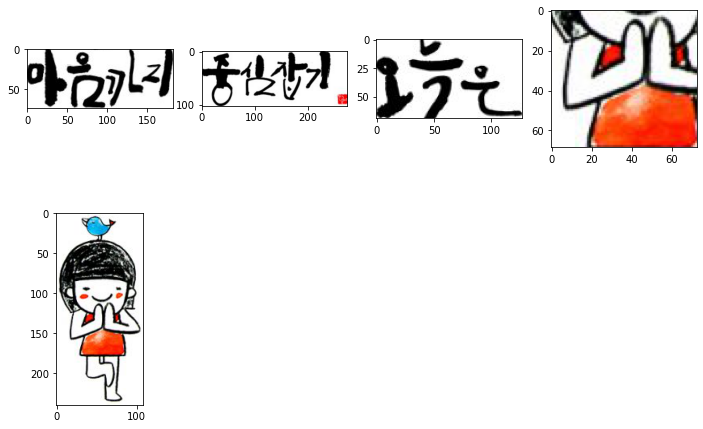

In [98]:
# 위에서 detection한 이미지를 가져오겠습니다.
Tesseract_detection_images = [Image.open(file) for file in glob.glob(kor_root_dir+"/Tesseract_result/*.*")]

plt.figure(figsize = (12,12))
for i, tesseract in enumerate(Tesseract_detection_images):
    plt.subplot(3,4,i+1)
    plt.imshow(tesseract)

In [99]:
recognize_images(cropped_image_path_list)

겨우.

야호

0

호가


Done


결과는 위에서 생각한대로 인식이 잘안됐지만, 그래도 한글 글자 검출은 나쁘지 않게 된것 같습니다.  

Tesseract로 텍스트 검출 및 인식은 캘리그라피를 마지막으로 마치겠습니다.

## 3. 테스트 결과 정리
---

지금까지 총 3개의 오픈소스 기능들을 사용해서 OCR이 잘 되는지 테스트를 해봤습니다.  
이제 위의 시각화 된 결과들을 가지고 와서 비교해 보면서 확인해보겠습니다.


각 부문 별로 점수를 각기 매기고 마지막에 매긴 점수의 총 합을 나타내겠습니다.  
점수를 주는 기준은 다음과 같습니다.  

>1. 추가적인 데이터셋을 학습시키지 않아도 되는지 ( 주어진 오픈소스를 바로 사용가능한지 여부)
2. 텍스트 detecction이 얼마나 잘 되는지
3. 텍스트 recognition이 얼마나 잘 되는지
4. 사용하기에 간편한지

- 위 1번 항목의 경우 점수가 낮을수록 추가적인 학습이 필요합니다.

위 총 4개의 기준을 가지고 점수를 1-5점까지 매기겠습니다.


### Correct placement

--- 

#### Google OCR API

1개의 이미지가 아닌 여러개의 이미지를 부를 경우 텍스트 인식 결과 부분이 제대로 안보이므로  
Google OCR API는 1개의 이미지만 불러오겠습니다.

In [137]:
google_ocr_dir = os.path.join(kor_root_dir,'google_ocr_Result')
google_ocr_dir

'/home/ssac27/aiffel/ocr_python/korea/google_ocr_Result'

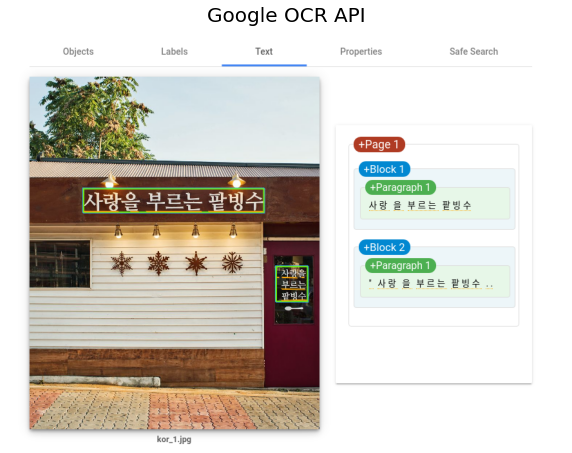

In [164]:

corr = [Image.open(file) for file in glob.glob(google_ocr_dir+"/Correct_placement/*.*")]

labels = "Google OCR API"
plt.figure(figsize = (10,10))

plt.title(labels, fontsize=20)
plt.axis('off')
plt.imshow(corr[0])


### keras-ocr

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


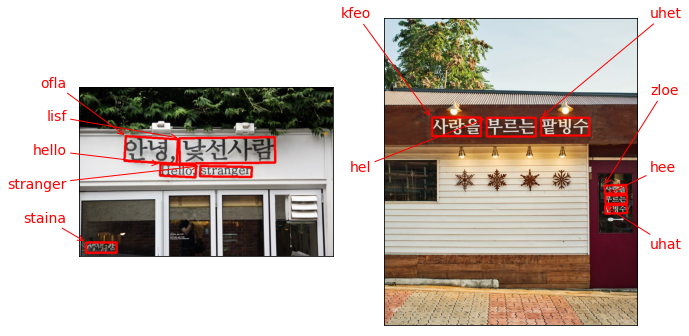

In [3]:
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/Correct_placement/*.*")]


keras_images = [keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

# Plot the predictions
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract
- 테서렉트는 text recognition이 잘 안되었기에 원할한 비교를 위해 detection 부분만 가져오겠습니다.  
 

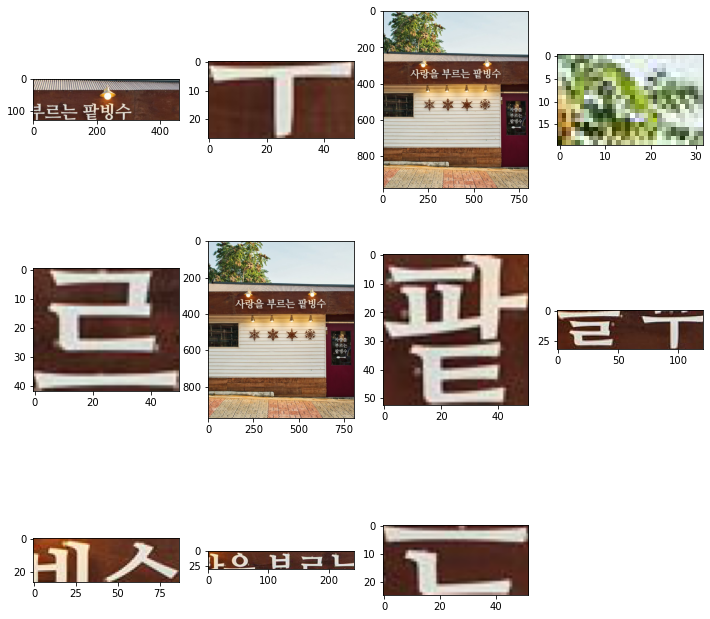

In [59]:
Tesseract_detection_images = [Image.open(file) for file in glob.glob(kor_root_dir+"/Tesseract_result/*.*")]

plt.figure(figsize = (12,12))
for i, tesseract in enumerate(Tesseract_detection_images):
    plt.subplot(3,4,i+1)
    plt.imshow(tesseract)

**Correct placement 부문 기능별 점수**

#### Google OCR API
1. 추가적인 학습 요구 : 5  &nbsp;&nbsp;&nbsp; [바로 사용 가능할 정도]
2. 텍스트 검출 : &nbsp; 5   
3. 텍스트 인식 : &nbsp; 5
4. 간편성 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : &nbsp; 5


#### keras-ocr
1. 추가적인 학습 요구 : 3  &nbsp;&nbsp;&nbsp; [한글 데이터셋 학습 필]
2. 텍스트 검출 : &nbsp; 5   
3. 텍스트 인식 : &nbsp; 3  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1번의 이유와 동일]
4. 간편성 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : &nbsp; 3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  [모델을 불러오고 검출-인식 까지의 시간이 오래걸림]

#### Tesseract
1. 추가적인 학습 요구 : 1 
2. 텍스트 검출 : &nbsp; 2 &nbsp;&nbsp;  [제대로된 텍스트 검출은 아니지만 부분적인 검출이 이루어지긴 했다.]
3. 텍스트 인식 : &nbsp; 1 
4. 간편성 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : &nbsp; 3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  [사용하기는 간편하다.]


- Correct placement에선 Google OCR API 가장 좋은 점수를 받았다. 


---

### Vertical_placement


#### Google OCR API

In [137]:
google_ocr_dir

'/home/ssac27/aiffel/ocr_python/korea/google_ocr_Result'

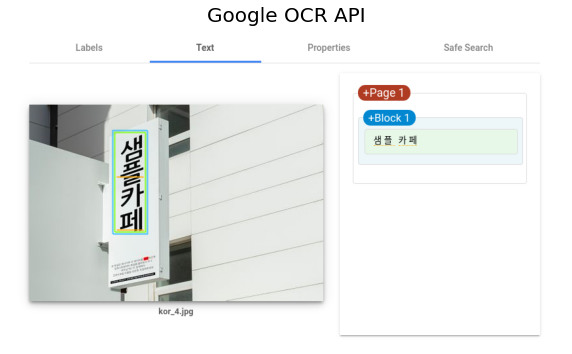

In [166]:
corr = [Image.open(file) for file in glob.glob(google_ocr_dir+"/Vertical_placement/*.*")]

labels = "Google OCR API"
plt.figure(figsize = (10,10))

plt.title(labels, fontsize=20)
plt.axis('off')
plt.imshow(corr[1])


### keras-ocr

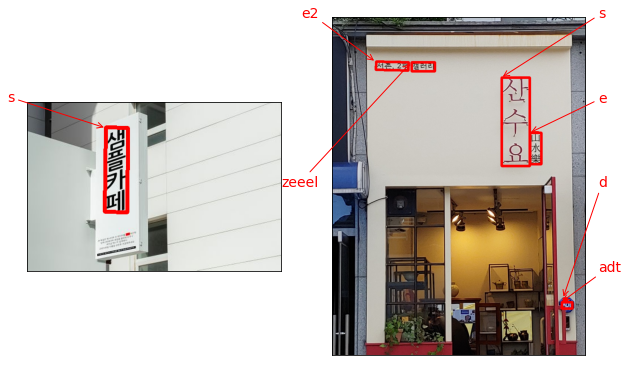

In [13]:
# image path from local
image_paths = [image_path for image_path in glob.glob(kor_root_dir+"/Vertical_placement/*.*")]

# use keras_ocr detection image 
keras_images = [keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

# Plot the predictions
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=keras_images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract
- 테서렉트는 text recognition이 잘 안되었기에 원할한 비교를 위해 detection 부분만 가져오겠습니다.  

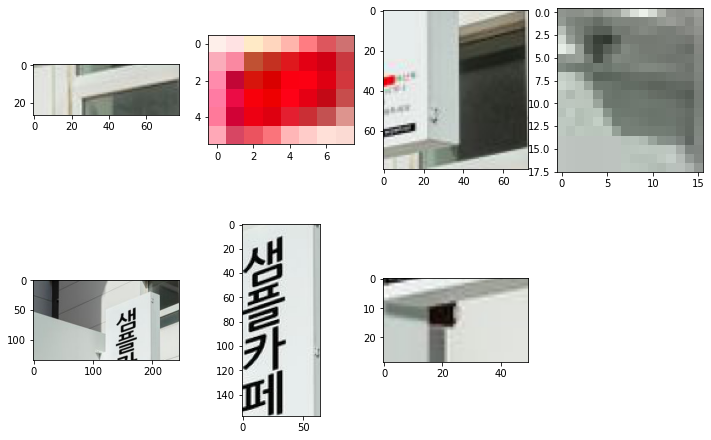

In [25]:
# 위에서 detection한 이미지를 가져오겠습니다.
Tesseract_detection_images = [Image.open(file) for file in glob.glob(kor_root_dir+"/Tesseract_result/*.*")]

plt.figure(figsize = (12,12))
for i, tesseract in enumerate(Tesseract_detection_images):
    plt.subplot(3,4,i+1)
    plt.imshow(tesseract)

**Vertical placement 부문 기능별 점수**

#### Google OCR API
1. 추가적인 학습 요구 : 5  &nbsp;&nbsp;&nbsp; [문장 단위도 제대로 인식 되었다.]
2. 텍스트 검출 : &nbsp; 5   
3. 텍스트 인식 : &nbsp; 5
4. 간편성 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : &nbsp; 5


#### keras-ocr
1. 추가적인 학습 요구 : 3  &nbsp;&nbsp;&nbsp; [한글 데이터셋 학습 필]
2. 텍스트 검출 : &nbsp; 5   
3. 텍스트 인식 : &nbsp; 3  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1번의 이유와 동일]
4. 간편성 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : &nbsp; 3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  [모델을 불러오고 검출-인식 까지의 시간이 오래걸림]

#### Tesseract
1. 추가적인 학습 요구 : 1 
2. 텍스트 검출 : &nbsp; 2 &nbsp;&nbsp;  [제대로된 텍스트 검출은 아니지만 부분적인 검출이 이루어지긴 했다.]
3. 텍스트 인식 : &nbsp; 1 
4. 간편성 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; : &nbsp; 3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  [사용하기는 간편하다.]


- Vertical placement에선 Google OCR API 가장 좋은 점수를 받았습니다. 

총 2개의 부문에서 **`Google OCR API`**가 가장 좋은 결과를 받았고 그 다음으로 **`keras-ocr`**이 좋은 결과를 받았습니다.  

이 순위가 다른 2 부문에서도 큰 차이없이 진행될것 같으니 비교 분석은 **Vertical placement**를 마지막으로 마치겠습니다. 


### 4. 결과 분석과 결론 제시
---
3가지 API를 테스트해보고 이제 특정 서비스를 제공한다고 했을때 어떤 API가 가장 부합한지 생각해 봅시다.  

- 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.

- 위에서 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.

- 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

#### 서비스의 목적    
시장 거리 간판의 텍스를 검출하고 인식해서 해당 시장 거리가 어떤 상권을 가지고 있는지 데이터를 분석해서 소상공인들의 시장 접근을 도우고자 한다.  

<br>

#### 내용
홍대나 건대 등의 시장 거리를 촬영을 해서 이미지 데이터를 모으고 그 이미지에서 간판의 텍스트를 인식해서 해당 시장 거리가 어떤 장사 위주로 하는지를 분석하는 서비스이다.  그리고 그 시장 거리의 상권과 비슷하지만 별로 없는 종목을 추천해 틈새 시장을 노리고 새롭게 장사를 시작하려는 소상공인들을 위한 **상권 분석 틈새 시장 추천 시스템**이라고 볼 수 있다.

#### 서비스 목적에 따른 부합 모델 평가
위 서비스들을 하기에 필요한 요소들을 평가기준으로 나타내겠습니다.  

1. **안정성**
- 시장의 트렌드는 빠르게 변화하고 있습니다. 그에 맞게 1달 전에 데이터를 분석했음에도 이번달에 새로운 트렌드가 급 부상할 수 있기에 한번 사용할 때 다음에 다시 학습을 시키거나 하는 경우가 가능하면 없는것이 더 편하면서 유용할 것입니다.  


2. **정확성**  
- 상권을 분석해서 어떤 전략을 가지고 해당 상권의 들어갈지 정보를 제공해주는 서비스이기에 그 정확도가 가장 중요합니다.  
[ 텍스트의 검출이 제대로 안되거나 인식이 제대로 안되서 중요한 데이터를 놓칠 수 있기 때문에 **'간판의 이미지를 보고 텍스트를 얼마나 잘 검출하는지'** ,**'그 검출한  텍스트의 인식은 얼마나 잘 되는지'**가 중요합니다. ]


3. **최소한의 서비스 하기까지 걸리는 시간과 비용**
- 완벽한 서비스 제공이 아닌 '최소한 이정도면 서비스를 제공할 수 있겠다' 하는데까지 '시간이 얼마나 걸리는지'와 서비스가 될 모델을 만들기 위한 하드웨어의 '비용이 얼마나 발생' 하는지도 고려를 해볼 요소이다.  

4. **텍스트 검출-인식 속도**  
- 아무리 성능이 좋더라도 정작 필요한 데이터를 뽑아내는데 시간이 오래 걸린다면, 사용하기에 부담이 생길 수 있다.  
어떤 지역의 상권 정보를 요구하는 고객이 있는 경우 해당 상권 거리의 간판들을 촬영하고 데이터를 추출해야 하는데, 이 시간이 오래 걸린다면 고객이 기다려 주지 않고 더 빠른 정보를 주는 기업으로 갈 수 있기에 정보의 빠른 업데이트 요소는 중요하다.


<br>

***안정성*** *부분 같은 경우 제대로 평가하려면 한글, 영어, 한자 등 다양한 간판 이미지들을 테스트해야하고 글자가 그림과 같이 생긴 간판들도 있기에 이 부분은 위의 평가기준에 적힌 말보다는 다소 복잡도를 낮춰서 현재 사용한 간판 이미지 중에서 글자의 배치나 크기에 상관없이 안정적이게 검출-인식이 이루어 졌는지를 평가하겠습니다.*

---


그럼 평가기준으로 **안정성, 정확성, 최소한의 서비스 하기까지 걸리는 시간과 비용, 텍스트 검출-인식 속도**의 4가지 조건을 두고 각 모델을 평가 하겠습니다.  


#### 안정성


1. **Google OCR API**  
안정성의 경우 위의 캘리그라피는 제외하고 간판 이미지들의 경우 안정적인 결과를 보였습니다.
<br>

2. **keras-ocr**  
keras-ocr의 경우 검출 부분에선 google보다 더 우수한 텍스트 검출을 보여줬습니다.  
그렇지만, 텍스트 인식의 경우 한글 데이터는 인식이 안되기 때문에 이 부분이 다소 아쉽네요.

<br>

3. **Tesseract**  
Tesseract의 경우 모든 경우에서 검출-인식이 잘 안되는 모습을 보여줬습니다.  

- 안정성의 경우 인식보다는 검출이 얼마나 유연하게 잘 되는지를 중요하게 판단해서 평가한 결과 **keras-ocr**이 3개 중에서 제일 좋은것 같습니다. 

<br>

#### 정확성

1. **Google OCR API**  
크기 차이가 많이 나는 문자의 경우 제대로 검출-인식을 하지 못했지만 대체로 준수한 성능을 보였습니다.

<br>

2. **keras-ocr**  
keras-ocr의 경우 텍스트 검출에선 Google 보다 유연하게 검출을 했지만, 한글 인식이 안되는 문제가 있기에 정확성을 평가하기에는 아쉬운 모습이 보입니다.

<br>

3. **Tesseract**  
Tesseract의 경우 **안정성**과 마찬가지로 모든 경우에서 검출-인식이 잘 안되는 모습을 보여줬습니다.  

- 정확성의 경우 종합적으로 봤을때 **Google OCR**이 제일 좋은 성능을 보인것 같습니다.

<br>

#### 서비스 하기까지의 걸리는 시간과 비용

1. **Google OCR API**  
Google 같은 경우 준수한 성능을 보이기에 API를 바로 사용해도 최소한의 서비스는 제공할 수 있을것 같습니다. 그리고 API를 결제해서 사용하면 되기에 추가적인 학습을 하는데 필요한 하드웨어를 구매할 비용이 줄어서 좀 더 경제적으로 평가됩니다.

<br>

2. **keras-ocr**  
keras-ocr의 경우 텍스트 검출은 뛰어나지만 한글 인식이 안되는 문제가 있어서 추가로 한글 데이터셋을 학습시켜야 하는데 이때 많은 데이터를 저장할 공간과 학습하는데 걸리는 시간을 줄여줄 그래픽 카드를 구매하는데 비용이 발생하기에 Google 보다 시간적, 물리적으로 비용이 더 발생하는것으로 평가됩니다. 

<br>

3. **Tesseract**  
Tesseract의 경우 모든 경우에서 제대로 검출-인식이 안되기에 아예 처음부터 모델을 학습하고 사용해야 합니다. 이렇게 될 경우 keras-ocr 보다 더 많은 시간과 비용이 소모될 것으로 보입니다.

- 시간과 비용의 소요를 봤을때 **Google OCR API**가 제일 경제적으로 보입니다.

<br>

####  텍스트 검출-인식 속도

1. **Google OCR API**  
Google의 경우 텍스트 검출-인식 속도가 상당히 빠른 속도로 10개의 이미지를 검출-인식 하는데 10분도 걸리지 않았습니다.  
<br>

2. **keras-ocr**  
keras-ocr의 경우 한 이미지의 검출-인식을 하는데 시간이 가장 많이 걸렸습니다.    
keras-ocr을 사용해서 2개의 간판 이미지들을 검출-인식 하는데 걸리는 시간이 Google OCR API로 모든 이미지를 검출-인식 하는데 걸리는 시간보다 훨씬 많이 걸렸습니다.

<br>

3. **Tesseract**  
Tesseract의 경우 검출-인식하는데 걸리는 시간이 Google OCR API와 비슷하게 빠른 속도를 보였습니다.  

- 텍스트 검출-인식 속도는 **Google OCR API**와 **Tesseract**가 거의 비슷한 속도를 보였습니다. 




---
이제 마지막으로 평가 기준에 따라서 가장 서비스의 부합한 모델을 선정하겠습니다.  

가장 부합하다고 평가된 모델은 바로 **Google OCR API**로 모든 경우에서 준수한 성능과 속도를 가졌습니다.  


위의 서비스를 실제로 제공한다고 가정했을때 **Google OCR API**를 활용해 서비스를 제공하는 것이 가장 나은 선택인것 같습니다.

---


## 회고  

- 이번 프로젝트에서 깊게 생각을 해본 부분이 바로 이 어떤 서비스를 제공할 것인지와 그 '서비스의 적합한 것은 무엇이냐'인것 같다.  
실제로 이런 기술을 가지고 있을때 어떤 서비스를 제공할 수 있는지 생각해 보면서 단순하게 기술만 공부하는 것이 아닌 그 기술을 어디에 어떻게 사용할 것인지를 생각해 볼 수 있어서 기술의 실효성에 대해 조금이나마 배운것 같습니다.  


- 프로젝트를 진행하면서 깨달은 부분은 기술이 서비스로 바뀔때 기존의 특정 분야에서 필요할것 같다고 생각한 기술이 다시 생각해보면 안 중요한 기술이 되버리면서 기존의 생각을 고치고 다시 생각하는 행위를 계속 반복했습니다.  
그렇게 나온 결과가 위의 서비스 인데 지금 회고를 작성하면서 위 서비스의 문제점이라고 보여지는 부분이 생각이 나네요.  


- 우선 위의 서비스에 틀에는 '간판에 해당 상점의 핵심이 들어가 있다' 라는 틀에서 서비스를 생각하고 제시했는데, 다시 생각해보니 위의 **안녕, 낯선사람**과 같은 해당 상점에 대한 아무런 내용이 없는 간판도 있음을 깨달았습니다.  
대부분의 경우 간판만 보면 상점이 어떤걸 파는지 알 수 있지만, 위의 **안녕, 낯선사람**과 **감성 언니**와 같이 간판만 보고 어떤 상점인지 모르는 경우가 있음을 생각하지 못하고 서비스를 제공할 시 나중엔 문제가 될 여지가 있어서 이 부분을 제대로 생각 못한것이 아쉽습니다.  


- 좀 더 이런 문제가 있음을 일찍 생각했다면, 다른 추가적인 대책을 생각해봤을텐데 어느새 시간이 많이 흘러서 추가적인 부분을 생각 못한것이 아쉽긴 합니다.  
그렇지만 이렇게라도 실제 서비스 제공에 대해서 생각해 볼 수 있었기에 의미있는 프로젝트를 진행한 것 같네요.
